In [4]:
import os
os.getcwd()

path_to_file = "/home/david/Documents/ml_projects/autoencoder/afm_patches_256.h5"


In [5]:
import h5py

with h5py.File(path_to_file, "r") as f:
    def visit(name, obj):
        if hasattr(obj, "shape"):
            print(f"{name:30s} {obj.shape}")
        else:
            print(name)
    f.visititems(visit)


patches
patches/aux_type               (202,)
patches/base_id                (202,)
patches/proc                   (202, 2, 256, 256)
patches/raw                    (202, 2, 256, 256)
patches/source_aux_file        (202,)
patches/source_topo_file       (202,)
patches/top_left_yx            (202, 2)
scans
scans/meta_jsonl               (43,)


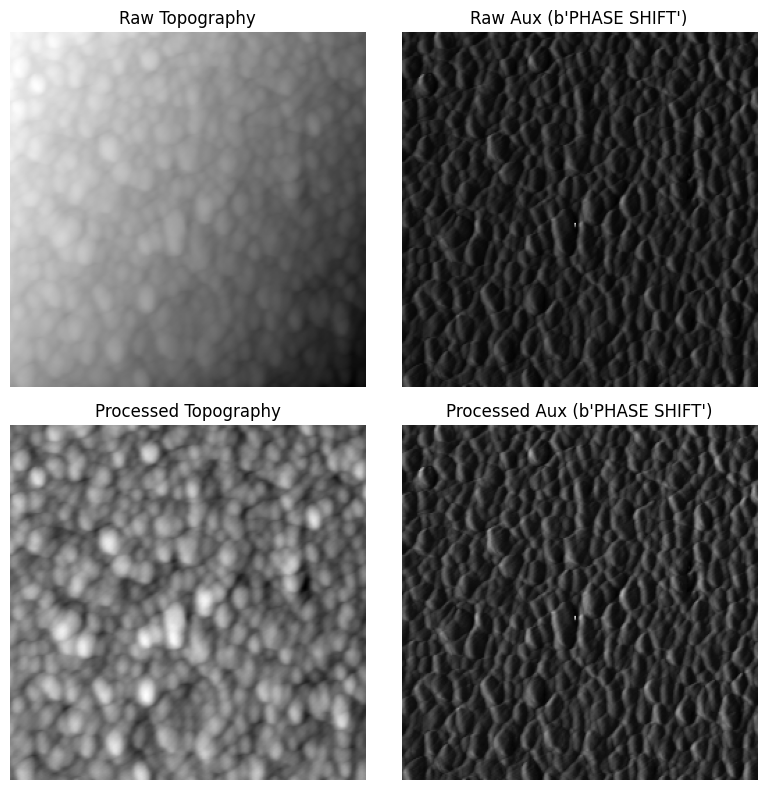

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

with h5py.File(path_to_file, "r") as f:
    raw = f["patches/raw"]
    proc = f["patches/proc"]
    aux_type = f["patches/aux_type"]

    i = np.random.randint(0, raw.shape[0])

    fig, ax = plt.subplots(2, 2, figsize=(8, 8))

    ax[0, 0].imshow(raw[i, 0], cmap="gray")
    ax[0, 0].set_title("Raw Topography")

    ax[0, 1].imshow(raw[i, 1], cmap="gray")
    ax[0, 1].set_title(f"Raw Aux ({aux_type[i]})")

    ax[1, 0].imshow(proc[i, 0], cmap="gray")
    ax[1, 0].set_title("Processed Topography")

    ax[1, 1].imshow(proc[i, 1], cmap="gray")
    ax[1, 1].set_title(f"Processed Aux ({aux_type[i]})")

    for a in ax.flat:
        a.axis("off")

    plt.tight_layout()
    plt.show()


## Check statistics

In [9]:
with h5py.File(path_to_file, "r") as f:
    proc = f["patches/proc"]

    topo = proc[:, 0]
    aux  = proc[:, 1]

    print("Topo  mean/std:", topo.mean(), topo.std())
    print("Aux   mean/std:", aux.mean(), aux.std())


Topo  mean/std: 2.9899667e-09 4.2265228e-08
Aux   mean/std: 8.5523786e-13 7.460743e-12


##  Filter Aux type

In [11]:
with h5py.File(path_to_file, "r") as f:
    aux_type = f["patches/aux_type"][:].astype(str)

    phase_idx = np.where(aux_type == "PHASE")[0]
    friction_idx = np.where(aux_type == "FRICTION")[0]

    print("Phase patches:", len(phase_idx))
    print("Friction patches:", len(friction_idx))


Phase patches: 0
Friction patches: 27


## Reconstruct full scan

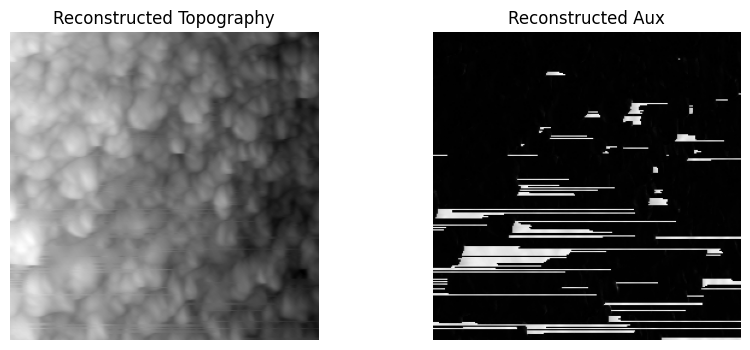

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

base_to_check = "samples070425_3"  # adjust

with h5py.File(path_to_file, "r") as f:
    raw = f["patches/raw"]
    base = f["patches/base_id"][:].astype(str)
    yx = f["patches/top_left_yx"][:]

    idxs = np.where(base == base_to_check)[0]
    if len(idxs) == 0:
        raise ValueError("No patches for this base_id")

    H = yx[idxs, 0].max() + 256
    W = yx[idxs, 1].max() + 256

    recon_topo = np.zeros((H, W), dtype=np.float32)
    recon_aux  = np.zeros((H, W), dtype=np.float32)

    for i in idxs:
        y, x = yx[i]
        recon_topo[y:y+256, x:x+256] = raw[i, 0]
        recon_aux[y:y+256, x:x+256] = raw[i, 1]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(recon_topo, cmap="gray")
plt.title("Reconstructed Topography")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(recon_aux, cmap="gray")
plt.title("Reconstructed Aux")
plt.axis("off")
plt.show()


## MetaData

In [14]:
import json
import h5py

with h5py.File(path_to_file, "r") as f:
    meta = json.loads(f["scans/meta_jsonl"][0])
    print(meta)


{'base_id': 'perovskite_s101024_14_26', 'topo_file': 'data/data_gwy/perovskite_s101024_14_26_T.gwy', 'aux_file': 'data/data_gwy/perovskite_s101024_14_26_FRICTION.gwy', 'aux_type': 'FRICTION', 'topo_meta': {'source_file': 'data/data_gwy/perovskite_s101024_14_26_T.gwy', 'channel_title': 'Topography', 'xres': 400, 'yres': 400, 'xreal_m': 5e-06, 'yreal_m': 5e-06, 'dx_m_per_px': 1.2500000000000001e-08, 'dy_m_per_px': 1.2500000000000001e-08, 'available_titles': [['/0/data/title', 'Topography']]}, 'aux_meta': {'source_file': 'data/data_gwy/perovskite_s101024_14_26_FRICTION.gwy', 'channel_title': 'Topography', 'xres': 400, 'yres': 400, 'xreal_m': 5e-06, 'yreal_m': 5e-06, 'dx_m_per_px': 1.2500000000000001e-08, 'dy_m_per_px': 1.2500000000000001e-08, 'available_titles': [['/0/data/title', 'Topography']]}, 'crop_border_frac': 0.05, 'clip_sigma': 8.0, 'patch': 256, 'stride': 128}
